In [1]:
import os
import numpy as np
import pandas as pd
from TSB_UAD.models.feature import Window
from TSB_UAD.utils.slidingWindows import find_length
from TSB_UAD.utils.visualisation import plotFig
from TSB_UAD.models.distance import Fourier
from TSB_UAD.vus.metrics import get_metrics
from TSB_UAD.models.matrix_profile import MatrixProfile
from TSB_UAD.models.iforest import IForest
from TSB_UAD.models.sand import SAND
from TSB_UAD.models.lstm import lstm
from TSB_UAD.models.lstm_streaming import lstm as lstm_streaming
from sklearn.preprocessing import MinMaxScaler
import math
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "1"

2025-06-10 00:51:55.997173: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749505916.018942 1634005 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749505916.029857 1634005 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1749505916.047292 1634005 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1749505916.047323 1634005 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1749505916.047325 1634005 computation_placer.cc:177] computation placer alr

Num GPUs Available:  1


In [ ]:
# Read data -- create/read a normality-2 dataset named `combined.csv`
# filepath = "data/TSB-UAD-Public/ECG/MBA_ECG14046_data_9.out"
ts1 = "../TSB-UAD-Public/ECG/MBA_ECG14046_data_9.out"
ts2 = "../TSB-UAD-Public/NASA-MSL/P-10.train.out"

ts1_test = "../TSB-UAD-Public/ECG/MBA_ECG14046_data_10.out" # assume next sequence is test
ts2_test = "../TSB-UAD-Public/NASA-MSL/P-10.test.out"

# df = pd.read_csv(filepath, header=None).dropna().to_numpy()

filepath = 'MBA_ECG14046_data_9+NASA-MSL_P-10.train.csv'
name = filepath.split('/')[-1]
if not os.path.exists(filepath):
    df1 = pd.read_csv(ts1, header=None).dropna().to_numpy()
    df2 = pd.read_csv(ts2, header=None).dropna().to_numpy()
    combined = np.vstack((df1, df2))
    pd.DataFrame(combined).to_csv(filepath, header=False, index=False)

df = pd.read_csv(filepath, header=None).dropna().to_numpy()
data = df[:, 0].astype(float)
labels = df[:, 1].astype(int)

filepath_stream = 'MBA_ECG14046_data_9+NASA-MSL_P-10.test.csv'
name_stream = filepath.split('/')[-1]
if not os.path.exists(filepath_stream):
    df1_test = pd.read_csv(ts1_test, header=None).dropna().to_numpy()
    df2_test = pd.read_csv(ts2_test, header=None).dropna().to_numpy()
    combined_test = np.vstack((df1_test, df2_test))
    pd.DataFrame(combined_test).to_csv(filepath_stream, header=False, index=False)

df_test = pd.read_csv(filepath_stream, header=None).dropna().to_numpy()
data_test = df_test[:, 0].astype(float)
labels_test = df_test[:, 1].astype(int)


In [2]:
# Read data -- create/read a normality-2 dataset named `combined.csv`
# filepath = "data/TSB-UAD-Public/ECG/MBA_ECG14046_data_9.out"
ts1 = "../TSB-UAD-Public/Occupancy/room-occupancy.train.csv@5.out"
ts2 = "../TSB-UAD-Public/YAHOO/YahooA3Benchmark-TS1_data.out"

ts1_test = "../TSB-UAD-Public/Occupancy/room-occupancy-1.test.csv@4.out" # assume next sequence is test
ts2_test = "../TSB-UAD-Public/YAHOO/Yahoo_A1real_1_data.out"

# df = pd.read_csv(filepath, header=None).dropna().to_numpy()

filepath = 'room-occupancy.train.csv.5+YahooA3Benchmark-TS1_data.csv'
name = filepath.split('/')[-1]
if not os.path.exists(filepath):
    df1 = pd.read_csv(ts1, header=None).dropna().to_numpy()
    df2 = pd.read_csv(ts2, header=None).dropna().to_numpy()
    combined = np.vstack((df1, df2))
    pd.DataFrame(combined).to_csv(filepath, header=False, index=False)

df = pd.read_csv(filepath, header=None).dropna().to_numpy()
data = df[:, 0].astype(float)
labels = df[:, 1].astype(int)

filepath_stream = 'room-occupancy-1.test.csv.4+Yahoo_A1real_1_data.csv'
name_stream = filepath.split('/')[-1]
if not os.path.exists(filepath_stream):
    df1_test = pd.read_csv(ts1_test, header=None).dropna().to_numpy()
    df2_test = pd.read_csv(ts2_test, header=None).dropna().to_numpy()
    combined_test = np.vstack((df1_test, df2_test))
    pd.DataFrame(combined_test).to_csv(filepath_stream, header=False, index=False)

df_test = pd.read_csv(filepath_stream, header=None).dropna().to_numpy()
data_test = df_test[:, 0].astype(float)
labels_test = df_test[:, 1].astype(int)


In [3]:
# Prepare data for unsupervised method

# filepath = './data/benchmark/ECG/MBA_ECG806_data.out'
# df = pd.read_csv(filepath, header=None).dropna().to_numpy()

# name = filepath.split('/')[-1]
max_length = 10000

# data = df[:max_length,0].astype(float)
# label = df[:max_length,1].astype(int)
    
slidingWindow = find_length(data)
# X_data = Window(window = slidingWindow).convert(data).to_numpy()


# Prepare data for semisupervised method. 
# Here, the training ratio = 0.1

# data_train = data[:int(0.1*len(data))]
# data_test = data

X_train = Window(window = slidingWindow).convert(data).to_numpy()
X_test = Window(window = slidingWindow).convert(data_test).to_numpy()

print("Estimated Subsequence length: ",slidingWindow)
print("Time series length: ",len(data))
print("Number of abnormal points: ",list(labels).count(1))

Estimated Subsequence length:  24
Time series length:  9823
Number of abnormal points:  1740


In [4]:
# Preprocessing
# slidingWindow = 10 # user defined

# or auto sliding window length
slidingWindow = find_length(data)
X_data = Window(window=slidingWindow).convert(data).to_numpy()
print(slidingWindow)
slidingWindow_test = find_length(data_test)
print(slidingWindow_test)
X_data_test = Window(window=slidingWindow_test).convert(data_test).to_numpy()

24
100


In [5]:
def evaluate(score, data, label, modelName, slidingWindow, name, predict=True):
    from TSB_UAD.vus import metrics
    from importlib import reload

    metrics = reload(metrics)

    # post processing
    score = (
        MinMaxScaler(feature_range=(0, 1)).fit_transform(score.reshape(-1, 1)).ravel()
    )
    if predict:
        score = np.array(
            [score[0]] * math.ceil((slidingWindow - 1) / 2)
            + list(score)
            + [score[-1]] * ((slidingWindow - 1) // 2)
        )
    results = metrics.get_metrics(
        score, label, metric="all", slidingWindow=slidingWindow
    )
    for metric in results.keys():
        print(metric, ":", results[metric])

    plotFig(
        data[: len(score)],
        label[: len(score)],
        score,
        slidingWindow,
        fileName=name,
        modelName=modelName,
    )

In [ ]:
modelName='LSTM' 
clf = lstm(slidingwindow = slidingWindow, predict_time_steps=1, epochs = 50, patience = 5, verbose=1)
clf.fit(X_data, X_test)
measure = Fourier()
measure.detector = clf
measure.set_param()
clf.decision_function(measure=measure)
        
score = clf.decision_scores_

I0000 00:00:1749502134.578564 1503245 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5318 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060 Ti, pci bus id: 0000:01:00.0, compute capability: 8.6
/home/periklis/Documents/University DWS 2024-2025/semester-2/MMDS/TSB-UAD/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


(8330, 24)
X=<tf.Tensor: shape=(8330, 24), dtype=float32, numpy=
array([[ 4.7486452e-03,  4.7390754e-03,  4.7295061e-03, ...,
         4.7794636e-03,  4.7834408e-03,  4.7929883e-03],
       [ 4.7486452e-03,  4.7486452e-03,  4.7390754e-03, ...,
         4.7715087e-03,  4.7794636e-03,  4.7834408e-03],
       [ 4.7102240e-03,  4.7486452e-03,  4.7486452e-03, ...,
         4.7569931e-03,  4.7715087e-03,  4.7794636e-03],
       ...,
       [ 2.1224448e+02,  4.5318439e+02,  4.6692419e+02, ...,
        -5.5215369e+02, -1.7469931e+02,  4.2559149e+02],
       [ 2.2395731e+02,  2.1224448e+02,  4.5318439e+02, ...,
        -5.0427271e+02, -5.5215369e+02, -1.7469931e+02],
       [ 2.8236795e+02,  2.2395731e+02,  2.1224448e+02, ...,
        -1.3937650e+03, -5.0427271e+02, -5.5215369e+02]], dtype=float32)>
(1470, 24)
X=<tf.Tensor: shape=(1470, 24), dtype=float32, numpy=
array([[ -223.50656,   282.36795,   223.9573 , ..., -1034.8877 ,
        -1393.765  ,  -504.2727 ],
       [-1240.6023 ,  -223.50656,

I0000 00:00:1749502138.364718 1503874 cuda_dnn.cc:529] Loaded cuDNN version 90300


    127/Unknown 4s 10ms/step - loss: 0.0772

2025-06-09 23:48:59.948481: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/home/periklis/Documents/University DWS 2024-2025/semester-2/MMDS/TSB-UAD/.venv/lib/python3.11/site-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


130/130 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - loss: 0.0766 - val_loss: 0.1267
Epoch 2/50
  8/130 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0791

2025-06-09 23:49:00.955332: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


129/130 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0540

2025-06-09 23:49:02.496161: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_6]]


130/130 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.0539 - val_loss: 0.1108
Epoch 3/50


2025-06-09 23:49:02.743251: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17870639050057003143
2025-06-09 23:49:02.743281: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17819102704696769073
2025-06-09 23:49:02.743286: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8967828184264019023


125/130 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0493

2025-06-09 23:49:04.988433: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_6]]
2025-06-09 23:49:04.988461: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6009646409282423852


130/130 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.0490 - val_loss: 0.1013
Epoch 4/50


2025-06-09 23:49:05.376345: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17870639050057003143
2025-06-09 23:49:05.376374: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17819102704696769073
2025-06-09 23:49:05.376379: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8967828184264019023


130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0462

2025-06-09 23:49:07.549576: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 5166196939292226453
2025-06-09 23:49:07.549595: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 14729664980346572639
2025-06-09 23:49:07.549602: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14853417444520128580
2025-06-09 23:49:07.549605: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 2180971104777185824
2025-06-09 23:49:07.549610: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6009646409282423852
2025-06-09 23:49:07.549613: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15405401245924584728
2025-06-09 23:49:07.748365: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv 

130/130 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.0462 - val_loss: 0.0924
Epoch 5/50
110/130 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0414

AUC_ROC : 0.5448072292705295
AUC_PR : 0.3225904310604571
Precision : 1.0
Recall : 0.005850804485616773
F : 0.0116335433834222
Precision_at_k : 0.005850804485616773
Rprecision : 1.0
Rrecall : 0.013433772755806657
RF : 0.026511397423191283
R_AUC_ROC : 0.49612731288886125
R_AUC_PR : 0.29717483140469025
VUS_ROC : 0.4671977203186519
VUS_PR : 0.28411199954044963
Affiliation_Precision : 0.6265267085878866
Affiliation_Recall : 0.8943599674868247


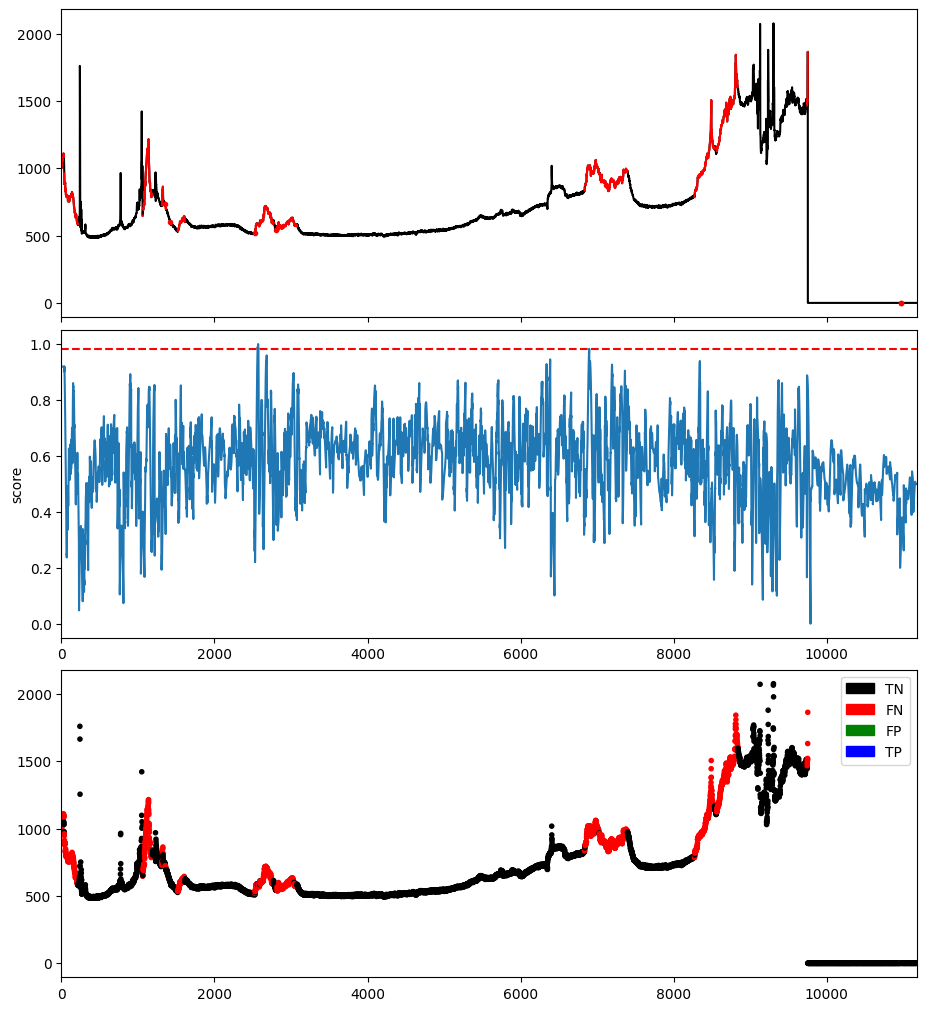

In [ ]:
evaluate(score, data_test, labels_test, modelName, slidingWindow, name, predict=True)

# Streaming

In [6]:
filepath_stream = 'MBA_ECG14046_data_9+NASA-MSL_P-10.test.csv'
name_stream = filepath.split('/')[-1]
if not os.path.exists(filepath_stream):
    df1_test = pd.read_csv(ts1_test, header=None).dropna().to_numpy()
    df2_test = pd.read_csv(ts2_test, header=None).dropna().to_numpy()
    combined_test = np.vstack((df1_test, df2_test))
    pd.DataFrame(combined_test).to_csv(filepath_stream, header=False, index=False)

df_stream = pd.read_csv(filepath_stream, header=None).dropna().to_numpy()
data_stream = df_stream[:, 0].astype(float)
labels_stream = df_stream[:, 1].astype(int)

In [7]:
# Initialize model for online (streaming) training
# slidingWindow = find_length(data)

clf = lstm(slidingwindow=slidingWindow, predict_time_steps=1, epochs=50, patience=5)

clf.fit(X_data, X_test)
measure = Fourier()
measure.detector = clf
measure.set_param()
clf.decision_function(measure=measure)
        
score = clf.decision_scores_

I0000 00:00:1749505924.770132 1634005 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5430 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060 Ti, pci bus id: 0000:01:00.0, compute capability: 8.6


(8330, 24)
X=<tf.Tensor: shape=(8330, 24), dtype=float32, numpy=
array([[ 4.7486452e-03,  4.7390754e-03,  4.7295061e-03, ...,
         4.7794636e-03,  4.7834408e-03,  4.7929883e-03],
       [ 4.7486452e-03,  4.7486452e-03,  4.7390754e-03, ...,
         4.7715087e-03,  4.7794636e-03,  4.7834408e-03],
       [ 4.7102240e-03,  4.7486452e-03,  4.7486452e-03, ...,
         4.7569931e-03,  4.7715087e-03,  4.7794636e-03],
       ...,
       [ 2.1224448e+02,  4.5318439e+02,  4.6692419e+02, ...,
        -5.5215369e+02, -1.7469931e+02,  4.2559149e+02],
       [ 2.2395731e+02,  2.1224448e+02,  4.5318439e+02, ...,
        -5.0427271e+02, -5.5215369e+02, -1.7469931e+02],
       [ 2.8236795e+02,  2.2395731e+02,  2.1224448e+02, ...,
        -1.3937650e+03, -5.0427271e+02, -5.5215369e+02]], dtype=float32)>
(1470, 24)
X=<tf.Tensor: shape=(1470, 24), dtype=float32, numpy=
array([[ -223.50656,   282.36795,   223.9573 , ..., -1034.8877 ,
        -1393.765  ,  -504.2727 ],
       [-1240.6023 ,  -223.50656,

/home/periklis/Documents/University DWS 2024-2025/semester-2/MMDS/TSB-UAD/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50


I0000 00:00:1749505928.811014 1634591 cuda_dnn.cc:529] Loaded cuDNN version 90300


    130/Unknown 5s 13ms/step - loss: 0.0682

2025-06-10 00:52:10.834434: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-06-10 00:52:10.834461: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/sequential_1/lstm_1/Shape/_2]]
2025-06-10 00:52:10.834474: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11539528450888990823
2025-06-10 00:52:10.834480: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12837966519884497373
2025-06-10 00:52:10.834486: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14322499274742389194
2025-06-10 00:52:10.834490: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key 

130/130 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - loss: 0.0681 - val_loss: 0.1822
Epoch 2/50
  9/130 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.1207

2025-06-10 00:52:11.771241: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_6]]
2025-06-10 00:52:11.771270: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13807425868522826559
2025-06-10 00:52:11.771275: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7277737568421117731
2025-06-10 00:52:11.771280: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3880530494733204862


127/130 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0626

2025-06-10 00:52:13.467518: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11539528450888990823
2025-06-10 00:52:13.467546: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12837966519884497373
2025-06-10 00:52:13.467553: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14322499274742389194
2025-06-10 00:52:13.467558: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 9470984165889246326


130/130 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0623 - val_loss: 0.0824
Epoch 3/50
126/130 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0451

2025-06-10 00:52:15.537988: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-06-10 00:52:15.538014: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11539528450888990823
2025-06-10 00:52:15.538037: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 9470984165889246326


130/130 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0449 - val_loss: 0.1391
Epoch 4/50
  7/130 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.0997

2025-06-10 00:52:15.755455: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13807425868522826559
2025-06-10 00:52:15.755480: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7277737568421117731
2025-06-10 00:52:15.755486: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3880530494733204862


127/130 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0525

2025-06-10 00:52:17.522875: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11539528450888990823
2025-06-10 00:52:17.522914: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 9470984165889246326


130/130 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0522 - val_loss: 0.0850
Epoch 5/50
130/130 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0401 - val_loss: 0.0852
Epoch 6/50


2025-06-10 00:52:19.584085: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-06-10 00:52:19.584139: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13807425868522826559
2025-06-10 00:52:19.584147: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7277737568421117731
2025-06-10 00:52:19.584168: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3880530494733204862


128/130 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0390

2025-06-10 00:52:22.254815: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11539528450888990823
2025-06-10 00:52:22.254840: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12837966519884497373
2025-06-10 00:52:22.254849: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14322499274742389194
2025-06-10 00:52:22.254853: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 9470984165889246326


130/130 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 0.0389 - val_loss: 0.0887
Epoch 7/50
130/130 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0394 - val_loss: 0.0891
Epoch 7: early stopping


2025-06-10 00:52:24.456092: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13807425868522826559
2025-06-10 00:52:24.456112: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7277737568421117731
2025-06-10 00:52:24.456118: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3880530494733204862


(11149, 24)
X=<tf.Tensor: shape=(11149, 24), dtype=float32, numpy=
array([[1.0832500e+03, 1.0870000e+03, 1.0753334e+03, ..., 1.0037500e+03,
        1.0000000e+03, 1.0296666e+03],
       [1.0863334e+03, 1.0832500e+03, 1.0870000e+03, ..., 1.0095000e+03,
        1.0037500e+03, 1.0000000e+03],
       [1.0910000e+03, 1.0863334e+03, 1.0832500e+03, ..., 1.0056667e+03,
        1.0095000e+03, 1.0037500e+03],
       ...,
       [1.9744147e-01, 1.3762613e-01, 1.5967482e-01, ..., 1.0149108e-01,
        2.1988772e-01, 3.4385029e-02],
       [1.6196617e-01, 1.9744147e-01, 1.3762613e-01, ..., 1.0269981e-01,
        1.0149108e-01, 2.1988772e-01],
       [1.1164835e-01, 1.6196617e-01, 1.9744147e-01, ..., 1.1258760e-01,
        1.0269981e-01, 1.0149108e-01]], dtype=float32)>
174/174 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step


In [8]:
clf.setStreaming(True)
modelName='LSTM' 

i = 0
# Simulate real-time data processing
for x, y in zip(data_stream, labels_stream):
    clf.partial_fit(x, y)
    # if z_score is not None and abs(z_score) > clf.retrain_z_thresh:
        # print(f"Anomaly detected with z-score {z_score:.2f}")
        # print("Re-evaluating")
        
    i+=1

measure = Fourier()
measure.detector = clf
measure.set_param()
clf.decision_function(measure=measure)
    
score = clf.decision_scores_

print(f"{score.shape=} {data_stream.shape=} {labels_stream.shape=}")

UnboundLocalError: cannot access local variable 'a_x' where it is not associated with a value

In [12]:
print(score.shape)

(11149,)


In [13]:
evaluate(score, data_stream[:len(score)], labels_stream[:len(score)], modelName, slidingWindow, name_stream, predict=False)

All labels are 0. Label must have groud truth value for calculating AUC score.


/home/periklis/Documents/University DWS 2024-2025/semester-2/MMDS/TSB-UAD/TSB_UAD/vus/utils/metrics.py:441: RuntimeWarning: invalid value encountered in scalar divide
  recall = min(TP / P_new, 1)
/home/periklis/Documents/University DWS 2024-2025/semester-2/MMDS/TSB-UAD/TSB_UAD/vus/utils/metrics.py:286: RuntimeWarning: invalid value encountered in scalar divide
  recall = min(TP/P_new,1)


TypeError: cannot unpack non-iterable NoneType object

AUC_ROC : 0.5377203165344974
AUC_PR : 0.10673764900112394
Precision : 0.30143784196462653
Recall : 0.10394910048266784
F : 0.15458905673920845
Precision_at_k : 0.10394910048266784
Rprecision : 0.26907917741642984
Rrecall : 0.09938210526322833
RF : 0.1451531348947283
R_AUC_ROC : 0.8206725071024382
R_AUC_PR : 0.2779464623639834
VUS_ROC : 0.7215768283114047
VUS_PR : 0.19099228230070384
Affiliation_Precision : 0.8122977849158274
Affiliation_Recall : 0.09200945640959314


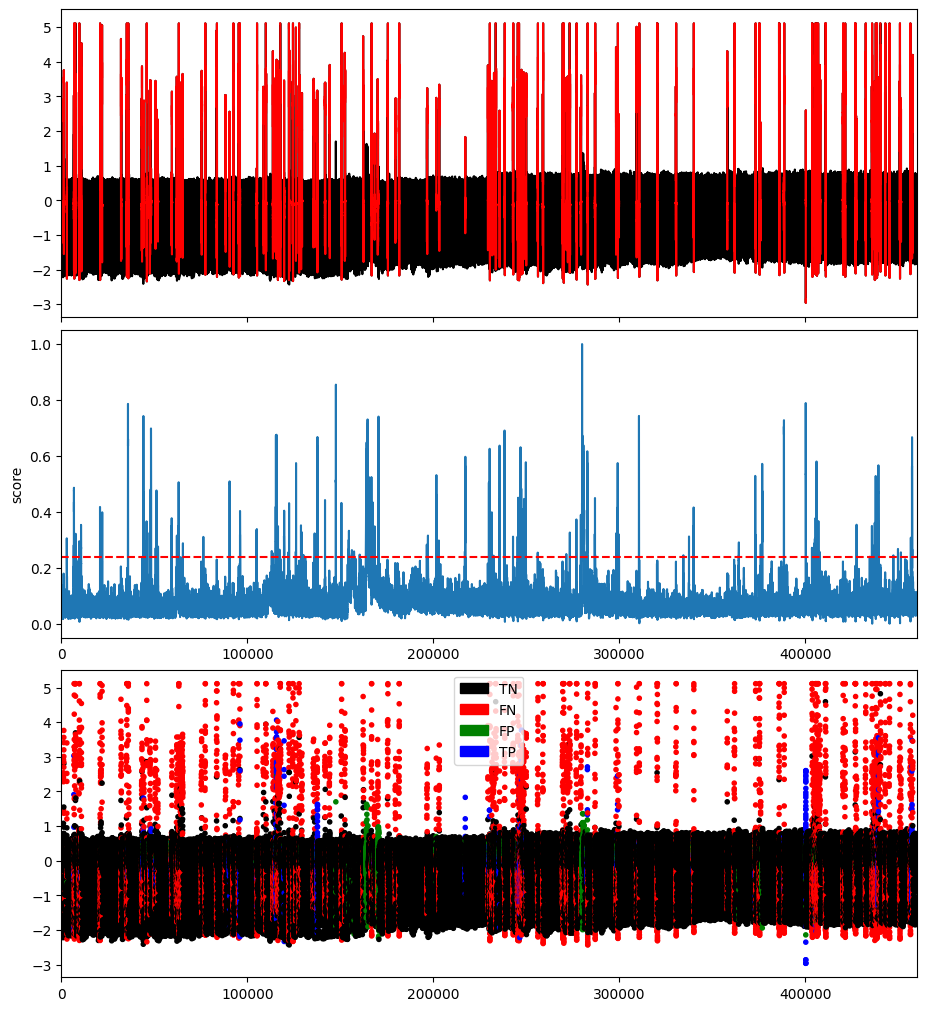

In [ ]:
# Run MatrixProfile
modelName = 'MatrixProfile'
clf = MatrixProfile(window=slidingWindow) # takes 1.5 minutes
clf.fit(data)
score = clf.decision_scores_
evaluate(score, modelName, slidingWindow, name)

AUC_ROC : 0.9450712729053256
AUC_PR : 0.6622921734932949
Precision : 0.7016784683975872
Recall : 0.46959192628345764
F : 0.5626412912044582
Precision_at_k : 0.46959192628345764
Rprecision : 0.5289925826524243
Rrecall : 0.38044350160139556
RF : 0.44258589240073615
R_AUC_ROC : 0.993741611421336
R_AUC_PR : 0.92925813361278
VUS_ROC : 0.9886584980120651
VUS_PR : 0.8556782179685721
Affiliation_Precision : 0.95789127594948
Affiliation_Recall : 0.7664418843997189


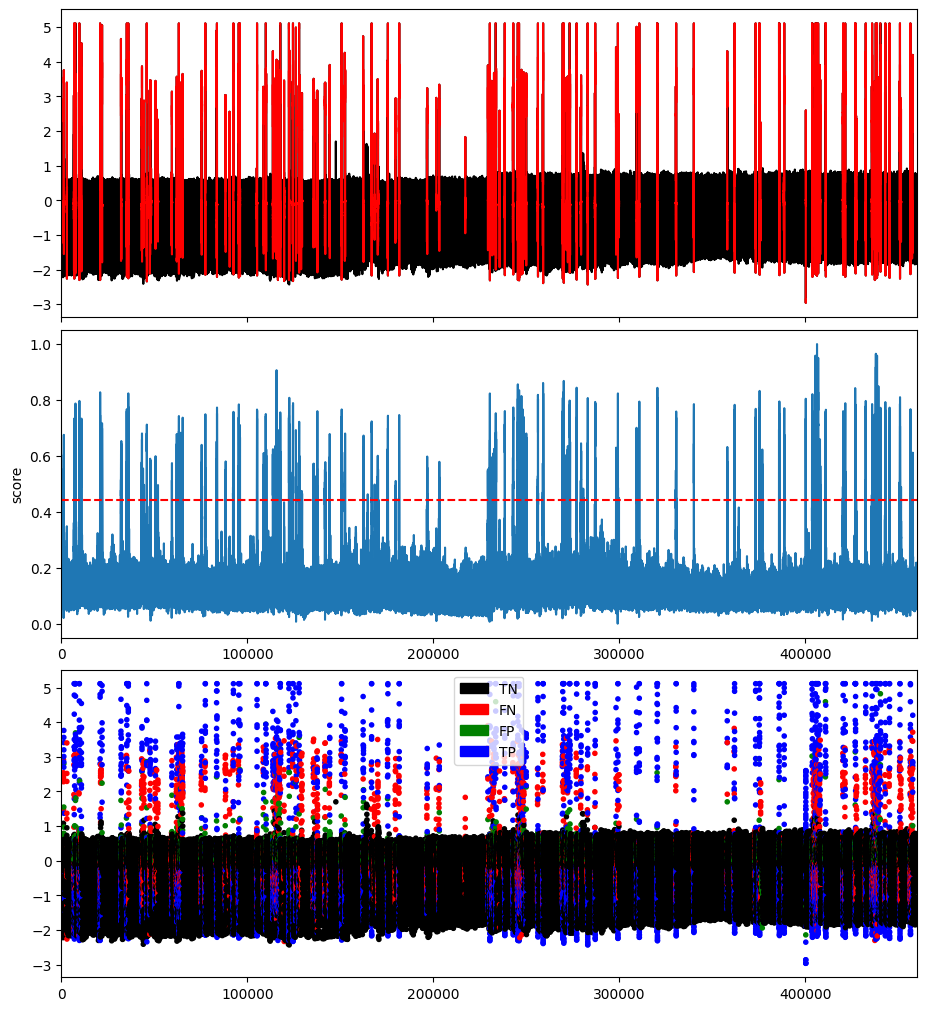

In [ ]:
# Run Isolation Forest
modelName = 'IForest'
clf = IForest(n_jobs=1)
x = X_data
clf.fit(x)
score = clf.decision_scores_
evaluate(score, modelName, slidingWindow, name)

In [ ]:
# SAND online
# ---- WARNING: this takese 40 mins to complete!!
modelName = 'SAND (online)'
clf = SAND(pattern_length=slidingWindow, subsequence_length=4*slidingWindow)
# length = len(data)//100 # not sure ?
clf.fit(data, overlaping_rate=int(4*slidingWindow), online=True, alpha=.5, init_length=5000, batch_size=2000,verbose=True,) # 100 batches 
score = clf.decision_scores_
evaluate(score, modelName, name=name, slidingWindow=slidingWindow, predict=False)

0-->5000-->7000-->9000-->11000-->13000-->15000-->17000-->19000-->21000-->23000-->25000-->27000-->29000-->31000-->33000-->35000-->37000-->39000-->41000-->43000-->45000-->47000-->49000-->51000-->53000-->55000-->57000-->59000-->61000-->63000-->65000-->67000-->69000-->71000-->73000-->75000-->77000-->79000-->81000-->83000-->85000-->87000-->89000-->91000-->93000-->95000-->97000-->99000-->101000-->103000-->105000-->107000-->109000-->111000-->113000-->115000-->117000-->119000-->121000-->123000-->125000-->127000-->129000-->131000-->133000-->135000-->137000-->139000-->141000-->143000-->145000-->147000-->149000-->151000-->153000-->155000-->157000-->159000-->161000-->163000-->165000-->167000-->169000-->171000-->173000-->175000-->177000-->179000-->181000-->183000-->185000-->187000-->189000-->191000-->193000-->195000-->197000-->199000-->201000-->203000-->205000-->207000-->209000-->211000-->213000-->215000-->217000-->219000-->221000-->223000-->225000-->227000-->229000-->231000-->233000-->235000-->237

TypeError: evaluate() takes 2 positional arguments but 4 were given

In [ ]:
%load_ext autoreload
evaluate(score, modelName, name=name, slidingWindow=slidingWindow, predict=False)

IndexError: list index out of range